In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def load_dataset(data_path, transform, bs=32, nw=1):
    train_dataset = torchvision.datasets.ImageFolder(root=data_path,
        transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=bs, num_workers=nw, shuffle=True)
    return train_loader

In [4]:
train_data_path = './data/train'
val_data_path = './data/validation'
transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
batch_size = 32
num_workers = 2

train_dataloader = load_dataset(train_data_path, transform, batch_size, num_workers)
val_dataloader = load_dataset(val_data_path, transform, batch_size, num_workers)

class_names = ["alien", "predator"]

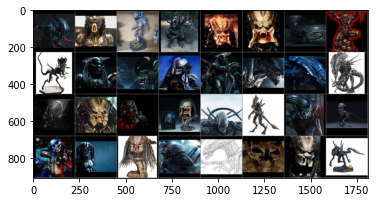

In [5]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp * 0.5 + 0.5
    inp = inp.numpy()
    plt.imshow(np.transpose(inp, (1, 2, 0)))
    plt.show()


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# Make a grid from batch
imshow(torchvision.utils.make_grid(images))

In [6]:
vgg_based = torchvision.models.vgg19(pretrained=True)
print(vgg_based)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
for param in vgg_based.parameters():
    param.requires_grad = False

number_features = vgg_based.classifier[6].in_features
layers = list(vgg_based.classifier.children())[:-1] # Remove last layer
layers.extend([torch.nn.Linear(number_features, len(class_names))])
vgg_based.classifier = torch.nn.Sequential(*layers)

vgg_based = vgg_based.to(device)
print(vgg_based)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
vgg_based.train()
train_loss = []
epochs = 5

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for data in train_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        with torch.set_grad_enabled(True):
            outputs = vgg_based(inputs)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)

    loss = running_loss / len(train_dataloader)
    train_loss.append(loss)
    print('epoch [%d/%d] loss: %.3f' % (epoch + 1, epochs, loss))

print('Finished Training')

epoch [1/5] loss: 13.705
epoch [2/5] loss: 8.472
epoch [3/5] loss: 7.228
epoch [4/5] loss: 6.811
epoch [5/5] loss: 6.081
Finished Training
